In [4]:
from contextlib import contextmanager

@contextmanager
def tag():
  print('start')
  yield
  print('end')

with tag():
  print('test')

start
test
end


In [15]:
def decorator(f):
  def wrapper(*args, **kwargs):
    print('decorator')
    return f(*args, **kwargs)
  return wrapper

@decorator 
def myprint(*args): 
  print(*args)

myprint(1,2,3)


decorator
1 2 3


# Word2Vec

In [2]:
# Если Вы запускаете ноутбук на colab,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git
import sys; sys.path.append('/content/stepik-dl-nlp')
!pip install spacy_udpipe

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 213 (delta 8), reused 19 (delta 5), pack-reused 190
Receiving objects: 100% (213/213), 42.11 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (87/87), done.
     |████████████████████████████████| 307kB 5.1MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625837 sha256=2ce8ab456356d9d943e4c4a6b83b8d6bc453974c9db7faa3c0e1cedf7e993409
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


In [0]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [199]:
#[[t for t in sent if t not in stopWords] for sent in train_tokenized[:10] ]
#train_tokenized[9]
 
# import spacy
# nlp = spacy.load('en')
# doc = nlp(train_tokenized[1])

# from spacy.lemmatizer import Lemmatizer
# from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

# lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
# lemmas = lemmatizer(u'ducks', u'NOUN')
# print(lemmas)

# print(train_tokenized[9])
# [[lemmatizer(t, u'NOUN')[0] for t in sent] for sent in train_tokenized[:9] ]

#выпилить (<a a>)

# a = 'dasf(<a a>)fsdf'
# import re
# re.sub('[\(<a*a>\)]','',a)

#df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
import re
s = '3 cups salsa (<a href="http://cooking.nytimes.com/recipes/1678-salsa-a-cold-tomato-and-chili-dish-or-relish">see recipe</a>)'
df = [re.sub('(\(<a).+?(a>)\)','',s) for s in df ]
df[1488]

'3 cups salsa '

In [0]:
# from spacy.lemmatizer import Lemmatizer
# from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

# lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

def make_dataset(nlp=None):
  # Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
  df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
  # df = [re.sub('[\(<a*a>\)]','',s) for s in df]

  if nlp is None:
    full_dataset = df
  else:
    full_dataset = []
    for doc in nlp.pipe(df):
      full_dataset.append(' '.join([token.lemma_ for token in doc]))

  random.shuffle(full_dataset)

  TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
  train_source = full_dataset[:TRAIN_VAL_SPLIT]
  test_source = full_dataset[TRAIN_VAL_SPLIT:]
  print("Обучающая выборка", len(train_source))
  print("Тестовая выборка", len(test_source))
  print()
  print('\n'.join(train_source[:10]))

  # токенизируем
  train_tokenized = tokenize_corpus(train_source)
  test_tokenized = tokenize_corpus(test_source)

  #clean stopwords
  # train_tokenized = [[t for t in sent if t not in stopWords] for sent in train_tokenized]
  # test_tokenized = [[t for t in sent if t not in stopWords] for sent in test_tokenized]
  
  # #lemmatizer NOUN
  # if lemmatizer is not None:
  #   train_tokenized = [[lemmatizer(t, u'NOUN')[0] for t in sent] for sent in train_tokenized ]
  #   test_tokenized = [[lemmatizer(t, u'NOUN')[0] for t in sent] for sent in test_tokenized ]

  print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))



  # строим словарь
  vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
  print("Размер словаря", len(vocabulary))
  print(list(vocabulary.items())[:10])

  # отображаем в номера токенов
  train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
  test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

  print('\n'.join(' '.join(str(t) for t in sent)
                  for sent in train_token_ids[:10]))


  plt.hist([len(s) for s in train_token_ids], bins=20);
  plt.title('Гистограмма длин предложений');

  MAX_SENTENCE_LEN = 20
  train_dataset = PaddedSequenceDataset(train_token_ids,
                                        np.zeros(len(train_token_ids)),
                                        out_len=MAX_SENTENCE_LEN)
  test_dataset = PaddedSequenceDataset(test_token_ids,
                                      np.zeros(len(test_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
  print(train_dataset[0])
  return train_dataset, test_dataset, vocabulary, MAX_SENTENCE_LEN

##Alt prepare corpus

In [111]:
df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
# for token in doc:
#   print(token.lemma_)
#doc = nlp(df[1])
#[ ''.join(token.lemma_)  for t in df[1] for token in nlp(t) ]

for doc in nlp.pipe(df[:10]):
  print(' '.join([token.lemma_ for token in doc]))
    #print(token.lemma_)


# full_dataset = []
# for sent in df[ :10]:
#   lem_sent = ''
#   for token in nlp(sent):
#     lem_sent += token.lemma_ + ' '
#   full_dataset.append(lem_sent[:-1])
# full_dataset

1 1/4 cup cook and pureed fresh butternut squash , or 1 10-ounce package freeze squash , defrost
1 cup peel and cook fresh chestnut ( about 20 ) , or 1 cup can , unsweetened chestnut
1 medium - size onion , peel and chop
2 stalk celery , chop coarse
1 1/2 tablespoon vegetable oil
2 tablespoon unflavore gelatin , dissolve in 1/2 cup water
salt
1 cup can plum tomato with juice
6 cup veal or beef stock
1/3 cup Worcestershire sauce


In [81]:
import re
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

df = list(pd.read_csv('/content/stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

import spacy
#nlp = spacy.load("en_core_web_sm") 

doc = nlp(df[1])   
for token in doc: 
  print(token, token.lemma_) 

#stopWords = set(stopwords.words('english'))

# from spacy.lang.en import English #, LOCAL_DATA_DIR

# import os

# #data_dir = os.environ.get('SPACY_DATA', LOCAL_DATA_DIR)
# nlp = English(parser=False, tagger=True, entity=False)


# def print_fine_pos(token):
#     return (token.tag_)

# def pos_tags(sentence):
#     #sentence = unicode(sentence, "utf-8")
#     tokens = nlp(sentence)
#     tags = []
#     for tok in tokens:
#         tags.append((tok,print_fine_pos(tok)))
#     return tags


# print(pos_tags(full_dataset[1]))

# def processing(df):
#     return(df)

# # df = processing(df)

# # df.head()

1 1
cup cup
peeled peel
and and
cooked cook
fresh fresh
chestnuts chestnut
( (
about about
20 20
) )
, ,
or or
1 1
cup cup
canned can
, ,
unsweetened unsweetened
chestnuts chestnut


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [5]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [0]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

поиграться с параметрами - количеством отрицательных слов, размером батча, скоростью обучения, размером окна
убрать разбиение текстов на предложения и увеличить окно
изменить токенизацию, например, разобравшись с библиотекой SpaCy и подключив лемматизацию и POS-теггинг, чтобы строить эмбеддинги не для словоформ, а для лемм (например, chicked_NOUN)
реализовать FastText и сравнить, как отличаются списки похожих документов, получаемых с помощью Word2Vec и FastText
усложнить алгоритм оценки вероятности совместной встречаемости слов, например, заменив скалярное произведение на нейросеть с парой слоёв

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounce swordfish , red snapper or other firm - fleshed fish
1 tablespoon mince basil leave
handful fresh parsley , finely mince
4 ounce lard or butter , plus more for brush top
4 to 5 green cardamom pod
1 stick ( 1/4 pound ) unsalted butter , soften
1/4 teaspoon red pepper flake , preferably turkish or Aleppo ( see note ) , more to taste
1 tablespoon fresh lemon juice
1/4 cup scallion , thinly slice
sour cream
ounce swordfish snapper other firm fleshed fish
tablespoon mince basil leave
handful fresh parsley finely mince
ounce lard butter plus more brush
green cardamom
stick pound unsalted butter soften
teaspoon pepper flake preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallion thinly slice
Размер словаря 1974
[('<PAD>', 0), ('tablespoon', 1), ('teaspoon', 2), ('chop', 3), ('salt', 4), ('pepper', 5), ('pound', 6), ('ground', 7), ('fresh', 8), ('taste', 9)]
218 49
11 786 520 115 237 636 175
1 

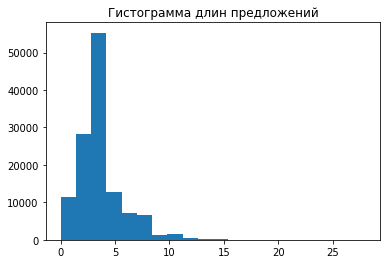

In [15]:
import spacy
nlp = spacy.load("en_core_web_sm") 

train_dataset, test_dataset, vocabulary, MAX_SENTENCE_LEN = make_dataset(nlp)

trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=3, negative_samples_n=25)

In [16]:
init_random_seed()

best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=2,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

#base line val - 0.877
#batch_size=16 - 0.873
#negative_samples_n=5 - 0.8837
#negative_samples_n=50 - 0.877
#negative_samples_n=30 - 0.877
#negative_samples_n=20 - 0.879
#radius=7 - 0.973
#radius=3 - 0.768
#lr=1e-3 - 0.881
#emb_size=150 - 0.879
#emb_size=50 - 0.876
#emb_size=80 -0.877
#batch_size=16+radius=3 - 0.765
#without stopwords - 0.88
#lemmatizer - 0.875
#nlp lemmatizer - 0.881
#del (<a*/a>) 0.882
#del (<a*/a>)+nlp lemmatizer+radius=3 - 0.775
#del (<a*/a>)+radius=3 - 0.773

Эпоха 0
Эпоха: 2001 итераций, 8.66 сек
Среднее значение функции потерь на обучении 0.7815246027389328
Среднее значение функции потерь на валидации 0.7744527906778581
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 9.33 сек
Среднее значение функции потерь на обучении 0.7734338732911967
Среднее значение функции потерь на валидации 0.7717587471895935
Новая лучшая модель!



In [0]:
# Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
torch.save(trainer.state_dict(), 'models/sgns.pth')

In [0]:
# Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
trainer.load_state_dict(torch.load('models/sgns.pth'))

## Исследуем характеристики полученных векторов

In [0]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [212]:
embeddings.most_similar('chicken')

[('chicken', 0.99993265),
 ('parsley', 0.6920049),
 ('skinned', 0.62827545),
 ('glaze', 0.5469205),
 ('sprinkling', 0.5342721),
 ('sticks', 0.53195006),
 ('cream', 0.525892),
 ('fruit', 0.5246256),
 ('spelt', 0.52307427),
 ('kimchi', 0.51622903)]

In [213]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cheese', 0.8907254),
 ('cacao', 0.82592857),
 ('oysters', 0.7487885),
 ('free', 0.7343919),
 ('fried', 0.73226905),
 ('irish', 0.7152783),
 ('pistachios', 0.66113234),
 ('juices', 0.6607586),
 ('bananas', 0.64648265),
 ('sausage', 0.6430469)]

In [214]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


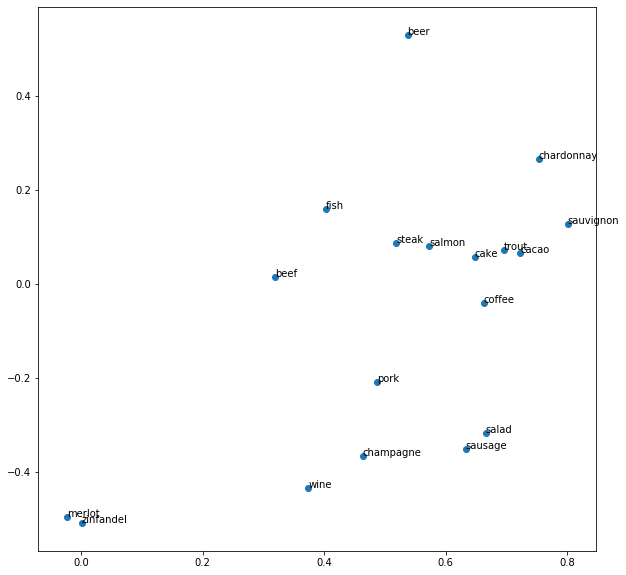

In [215]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [0]:
import gensim

In [0]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [38]:
word2vec.wv.most_similar('chicken')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('duck', 0.71314936876297),
 ('thighs', 0.6991573572158813),
 ('simmering', 0.6939100027084351),
 ('turkey', 0.6835533976554871),
 ('defatted', 0.6789121627807617),
 ('pheasant', 0.6745012998580933),
 ('breasts', 0.6706445217132568),
 ('drumsticks', 0.6660717725753784),
 ('wings', 0.6646468639373779),
 ('stock', 0.6566658020019531)]

In [0]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

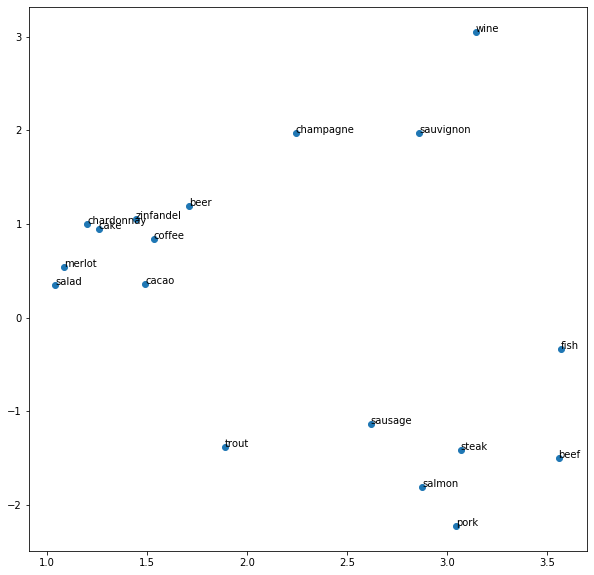

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [0]:
import gensim.downloader as api

In [0]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

In [0]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

In [0]:
pretrained.most_similar('cheese')

In [0]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [0]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают